<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
#torch.multiprocessing.set_start_method('spawn')
#torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 200
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 10
    
args = Parser()
#torch.manual_seed(args.seed)
#kwargs = {'num_workers': 1, 'pin_memory': False}

use_cuda = not args.no_cuda and torch.cuda.is_available()

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if not use_cuda else {}
print(use_cuda)

False


<b>Download MNIST Data using torchvision datasets module</b>

In [4]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    #print("######", params2[name1].shape, params2[name1])
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(name1, params1[name1].shape, neighbour_ptr.shape)
                    
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
                    #x = params1[name1].copy()
                    #x.get()
                    #print("parameter value", x)
        
        #for key, value in params1.items():
        #    print(key, value.shape)
        
                    
        #self.load_state_dict(params1, strict=False)
        self.load_state_dict(params1)
                             
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
    
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            #self.load_state_dict(params1, strict=False)
            self.load_state_dict(params1)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [6]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [7]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,1,8
1,8,9
2,3,10
3,5,9
4,1,5
5,1,9
6,2,8
7,2,4
8,1,7


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [8]:
def rotate_tuple_worker(worker_tuple):
    return worker_tuple[1:] + [worker_tuple[0]]

def generate_worker_split():
    random.seed(1)
    target_worker_split = {}
    total_mnist_numbers = 10
    mnist_numbers = list(range(10))
    for i in range(args.num_of_workers):
        mnist_worker_number = random.sample(mnist_numbers, 3)
        
        for mnist_number in mnist_worker_number:
            if mnist_number in target_worker_split:
                target_worker_split[mnist_number].append(i)
            else:
                target_worker_split[mnist_number] = []
                target_worker_split[mnist_number].append(i)
    
    return target_worker_split
            
    
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    #target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    target_worker_split = generate_worker_split()
    print(target_worker_split)
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], list):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = rotate_tuple_worker(target_worker_split[target_value])
        else:
            current_worker_idx = target_worker_split[target_value]
        
        #for current_worker_idx in target_worker_split[target_value]:
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
                      
        target_worker_dataset[current_worker_idx].append((data, target))
            
    for current_worker_idx in range(args.num_of_workers):
        if len(target_worker_dataset[current_worker_idx]):
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            #cuda#target_values = torch.cat(target_values).to(device)
            input_data = torch.cat(input_data)
            #cuda#input_data = torch.cat(input_data).to(device)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
        
    models = [Net() for _ in range(args.num_of_workers)]
    #for model in models:
    #    model.to(device)
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [9]:
def update(data, target, model, optimizer):
    #print(data, target)
    #for key, value in model.state_dict().items():
    #    print(model, key, value, value.shape)
    #CUDA#data, target = data.to(device), target.to(device)
    #print(data, target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
            
    return model, data, target

In [10]:
def check_accuracy(model, node):
    model.get()
    _, accuracy = test(model, node.id)
    return accuracy, model.send(node)

def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
    worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
    
    #Send worker2 params to worker1 for averaging at worker1
    #accuracy_before_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])
    
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    accuracy_after_exchange, models[worker_id1]  = check_accuracy(worker1_model, compute_nodes[worker_id1])

    #print("#########Node - {} accuracy before exchange - {} ; accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], accuracy_before_exchange, accuracy_after_exchange, worker1_model.previous_accuracy ))
    
    if accuracy_after_exchange < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = accuracy_after_exchange
        worker1_model.previous_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        
    
    #Send worker1 params to worker2 for averaging at worker2
    #accuracy_before_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    accuracy_after_exchange, models[worker_id2]  = check_accuracy(worker2_model, compute_nodes[worker_id2])
    #print("###########Node - {} accuracy before exchange - {} ;  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], accuracy_before_exchange, accuracy_after_exchange, worker2_model.previous_accuracy ))
    if accuracy_after_exchange < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = accuracy_after_exchange
        worker2_model.previous_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        
    return worker_id1, worker_id2

def exchange_parameters_all(models, data_index):
    exchange_combinations = list(itertools.combinations(range(len(models)), 2))
    random.shuffle(exchange_combinations)
    
    worker_list = list(range(len(compute_nodes)))
    
    
    #for worker_id1, worker_id2 in exchange_combinations:
    for worker_id1, worker_id2 in zip(worker_list, worker_list[1:] + [worker_list[0]]):
        worker1_model = models[worker_id1]
        worker2_model = models[worker_id2]
        #print("####MODELS",worker_id1, worker1_model, worker_id2, worker2_model)
        #for key, value in worker1_model.state_dict().items():
        #    print(worker_id1, key, value, value.shape)
            
        #for key, value in worker2_model.state_dict().items():
        #    print(worker_id2, key, value, value.shape)
            
        worker1_params = {key: value.copy() for key, value in worker1_model.state_dict().items()}
        worker2_params = {key: value.copy() for key, value in worker2_model.state_dict().items()}
        worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
        worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
        
        

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [11]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, decentralized=False):
    
    #for key, value in models[0].state_dict().items():
    #    print("BEFORE START - 0",models[0], key, value, value.shape)
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n", models[59].to(device), models[59].to(device).state_dict())
    
    if federated_average:
        #cuda#models = [models.copy().to(device) for _ in range(args.num_of_workers)]
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    
    #for key, value in models[59].state_dict().items():
    #    print("before START - 59", models[59], key, value, value.size())
        
    #models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    
    #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n")
    #for key, value in models[59].state_dict().items():
    #    print("AFTER SEND- 59", models[59], key, value, value.size())
    
    
    #print("#############################")
    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index], data, target = update(data, target, models[remote_index], optimizers[remote_index])
            remote_dataset[remote_index][data_index] = (data, target)
        
    
       #Exchange of parameter between two remote models.
    if decentralized:
        #worker_id1, worker_id2 = exchange_parameters(models, epoch_id)
        exchange_parameters_all(models, epoch_id)
        #for i in range(len(models)):
        #    if i not in (worker_id1, worker_id2):
        #        print(i, worker_id1, worker_id2)
        #        accuracy, models[i] = check_accuracy(models[i], compute_nodes[i])
        #        if accuracy < models[i].previous_accuracy:
        #            models[i].rollback_exchange()
                
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for i, model in enumerate(models):
        model.get()
        #if federated_average:
        #    _, current_accuracy = test(model, compute_nodes[i])
        #    print("###########Federated Average Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[i], current_accuracy, model.previous_accuracy ))
        #    model.previous_accuracy = current_accuracy
        
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [12]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #cuda#data, target = data.to(device), target.to(device)
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [13]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if decentralized:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, decentralized)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-04-06 07:59:12.941500
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker worker-0: Average loss: 9.0385 & Average Accuracy : 0.3000
Test set for worker worker-1: Average loss: 7.4828 & Average Accuracy : 0.2848
Test set for worker worker-2: Average loss: 6.8453 & Average Accuracy : 0.2897
Test set for worker worker-3: Average loss: 7.0314 & Average Accuracy : 0.3052
Test set for worker worker-4: Average loss: 6.3540 & Average Accuracy : 0.2877
Test set for worker worker-5: Average loss: 7.1292 & Average Accuracy : 0.2892
Test set for worker worker-6: Average loss: 17.7147 & Average Accuracy : 0.0892
Test set for worker worker-7: Average loss: 5.6250 & Average Accuracy : 0.2812
Test set for worker worker-8: Average loss: 5.7569 & Average Accuracy : 0.2782
Test set for worker worker-9: Average loss: 6.2528 & Average Accuracy : 0.2866
Communication t

Test set for worker worker-5: Average loss: 8.7804 & Average Accuracy : 0.2974
Test set for worker worker-6: Average loss: 10.4973 & Average Accuracy : 0.2994
Test set for worker worker-7: Average loss: 8.6463 & Average Accuracy : 0.2915
Test set for worker worker-8: Average loss: 9.4429 & Average Accuracy : 0.2863
Test set for worker worker-9: Average loss: 8.6562 & Average Accuracy : 0.2914
Communication time over the network 33.88 s

Epoch Number 11
Test set for worker worker-0: Average loss: 10.4268 & Average Accuracy : 0.3129
Test set for worker worker-1: Average loss: 10.0752 & Average Accuracy : 0.3093
Test set for worker worker-2: Average loss: 9.8129 & Average Accuracy : 0.2932
Test set for worker worker-3: Average loss: 10.4754 & Average Accuracy : 0.3123
Test set for worker worker-4: Average loss: 10.3749 & Average Accuracy : 0.2915
Test set for worker worker-5: Average loss: 8.7848 & Average Accuracy : 0.2978
Test set for worker worker-6: Average loss: 10.5499 & Average Acc

Test set for worker worker-1: Average loss: 10.1777 & Average Accuracy : 0.3107
Test set for worker worker-2: Average loss: 10.0171 & Average Accuracy : 0.2951
Test set for worker worker-3: Average loss: 11.0980 & Average Accuracy : 0.3125
Test set for worker worker-4: Average loss: 10.7204 & Average Accuracy : 0.2915
Test set for worker worker-5: Average loss: 8.9632 & Average Accuracy : 0.2991
Test set for worker worker-6: Average loss: 11.1109 & Average Accuracy : 0.3012
Test set for worker worker-7: Average loss: 8.7108 & Average Accuracy : 0.2927
Test set for worker worker-8: Average loss: 10.0390 & Average Accuracy : 0.2872
Test set for worker worker-9: Average loss: 8.8580 & Average Accuracy : 0.2922
Communication time over the network 33.58 s

Epoch Number 21
Test set for worker worker-0: Average loss: 11.2366 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 10.1867 & Average Accuracy : 0.3109
Test set for worker worker-2: Average loss: 10.0327 & Average 

Test set for worker worker-7: Average loss: 8.8031 & Average Accuracy : 0.2934
Test set for worker worker-8: Average loss: 10.3970 & Average Accuracy : 0.2874
Test set for worker worker-9: Average loss: 8.9839 & Average Accuracy : 0.2926
Communication time over the network 33.49 s

Epoch Number 30
Test set for worker worker-0: Average loss: 11.8756 & Average Accuracy : 0.3136
Test set for worker worker-1: Average loss: 10.2842 & Average Accuracy : 0.3112
Test set for worker worker-2: Average loss: 10.1954 & Average Accuracy : 0.2964
Test set for worker worker-3: Average loss: 11.5175 & Average Accuracy : 0.3129
Test set for worker worker-4: Average loss: 10.8895 & Average Accuracy : 0.2915
Test set for worker worker-5: Average loss: 9.3161 & Average Accuracy : 0.2998
Test set for worker worker-6: Average loss: 11.6599 & Average Accuracy : 0.3018
Test set for worker worker-7: Average loss: 8.8217 & Average Accuracy : 0.2934
Test set for worker worker-8: Average loss: 10.4334 & Average A

Test set for worker worker-3: Average loss: 11.8165 & Average Accuracy : 0.3129
Test set for worker worker-4: Average loss: 11.0369 & Average Accuracy : 0.2916
Test set for worker worker-5: Average loss: 9.7009 & Average Accuracy : 0.3000
Test set for worker worker-6: Average loss: 12.1819 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 9.0128 & Average Accuracy : 0.2936
Test set for worker worker-8: Average loss: 10.7347 & Average Accuracy : 0.2878
Test set for worker worker-9: Average loss: 9.1710 & Average Accuracy : 0.2927
Communication time over the network 33.4 s

Epoch Number 40
Test set for worker worker-0: Average loss: 12.4915 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 10.4755 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 10.4699 & Average Accuracy : 0.2975
Test set for worker worker-3: Average loss: 11.8468 & Average Accuracy : 0.3129
Test set for worker worker-4: Average loss: 11.0527 & Average A

Test set for worker worker-9: Average loss: 9.3991 & Average Accuracy : 0.2930
Communication time over the network 33.68 s

Epoch Number 49
Test set for worker worker-0: Average loss: 12.9536 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 10.7501 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 10.7584 & Average Accuracy : 0.2980
Test set for worker worker-3: Average loss: 12.1006 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 11.2313 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 10.1557 & Average Accuracy : 0.3001
Test set for worker worker-6: Average loss: 12.8151 & Average Accuracy : 0.3018
Test set for worker worker-7: Average loss: 9.2848 & Average Accuracy : 0.2937
Test set for worker worker-8: Average loss: 11.0740 & Average Accuracy : 0.2879
Test set for worker worker-9: Average loss: 9.4295 & Average Accuracy : 0.2932
Communication time over the network 33.84 s

Epoch Number 50
T

Test set for worker worker-5: Average loss: 10.5585 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 13.3454 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 9.5833 & Average Accuracy : 0.2938
Test set for worker worker-8: Average loss: 11.4876 & Average Accuracy : 0.2881
Test set for worker worker-9: Average loss: 9.6900 & Average Accuracy : 0.2932
Communication time over the network 33.81 s

Epoch Number 59
Test set for worker worker-0: Average loss: 13.4513 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 11.0823 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 11.0987 & Average Accuracy : 0.2983
Test set for worker worker-3: Average loss: 12.3566 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 11.4804 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 10.6027 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 13.4012 & Average

Test set for worker worker-1: Average loss: 11.4211 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 11.3819 & Average Accuracy : 0.2982
Test set for worker worker-3: Average loss: 12.5831 & Average Accuracy : 0.3130
Test set for worker worker-4: Average loss: 11.7521 & Average Accuracy : 0.2920
Test set for worker worker-5: Average loss: 10.9758 & Average Accuracy : 0.3007
Test set for worker worker-6: Average loss: 13.8682 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 9.9797 & Average Accuracy : 0.2942
Test set for worker worker-8: Average loss: 12.0027 & Average Accuracy : 0.2883
Test set for worker worker-9: Average loss: 9.9819 & Average Accuracy : 0.2934
Communication time over the network 33.97 s

Epoch Number 69
Test set for worker worker-0: Average loss: 13.9153 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 11.4614 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 11.4198 & Average

Test set for worker worker-7: Average loss: 10.3337 & Average Accuracy : 0.2942
Test set for worker worker-8: Average loss: 12.4475 & Average Accuracy : 0.2883
Test set for worker worker-9: Average loss: 10.2432 & Average Accuracy : 0.2935
Communication time over the network 36.02 s

Epoch Number 78
Test set for worker worker-0: Average loss: 14.3137 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 11.8267 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 11.6983 & Average Accuracy : 0.2984
Test set for worker worker-3: Average loss: 12.8329 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 12.0993 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 11.3542 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 14.3278 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 10.3774 & Average Accuracy : 0.2942
Test set for worker worker-8: Average loss: 12.4936 & Avera

Test set for worker worker-2: Average loss: 11.9798 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 13.0538 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 12.4450 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 11.6674 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 14.6963 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 10.7185 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 12.8859 & Average Accuracy : 0.2885
Test set for worker worker-9: Average loss: 10.5187 & Average Accuracy : 0.2936
Communication time over the network 36.67 s

Epoch Number 88
Test set for worker worker-0: Average loss: 14.7290 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 12.2354 & Average Accuracy : 0.3115
Test set for worker worker-2: Average loss: 12.0080 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 13.0790 & Avera

Test set for worker worker-8: Average loss: 13.2322 & Average Accuracy : 0.2886
Test set for worker worker-9: Average loss: 10.7477 & Average Accuracy : 0.2936
Communication time over the network 37.09 s

Epoch Number 97
Test set for worker worker-0: Average loss: 15.0891 & Average Accuracy : 0.3138
Test set for worker worker-1: Average loss: 12.5814 & Average Accuracy : 0.3115
Test set for worker worker-2: Average loss: 12.2678 & Average Accuracy : 0.2985
Test set for worker worker-3: Average loss: 13.2945 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 12.8287 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.0120 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 15.0598 & Average Accuracy : 0.3020
Test set for worker worker-7: Average loss: 11.0700 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 13.2681 & Average Accuracy : 0.2886
Test set for worker worker-9: Average loss: 10.7729 & Avera

Test set for worker worker-3: Average loss: 13.5052 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 13.1620 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.3124 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 15.3569 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 11.3541 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 13.5782 & Average Accuracy : 0.2886
Test set for worker worker-9: Average loss: 10.9852 & Average Accuracy : 0.2936
Communication time over the network 36.78 s

Epoch Number 107
Test set for worker worker-0: Average loss: 15.4564 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 12.9274 & Average Accuracy : 0.3115
Test set for worker worker-2: Average loss: 12.5307 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 13.5308 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 13.1975 & Aver

Test set for worker worker-9: Average loss: 11.1780 & Average Accuracy : 0.2936
Communication time over the network 33.34 s

Epoch Number 116
Test set for worker worker-0: Average loss: 15.7593 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 13.2056 & Average Accuracy : 0.3116
Test set for worker worker-2: Average loss: 12.7465 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 13.7335 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 13.5061 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.6230 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 15.6560 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 11.6331 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 13.8911 & Average Accuracy : 0.2887
Test set for worker worker-9: Average loss: 11.1975 & Average Accuracy : 0.2936
Communication time over the network 33.78 s

Epoch Number 

Test set for worker worker-4: Average loss: 13.7898 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.8870 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 15.8988 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 11.8601 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 14.1484 & Average Accuracy : 0.2887
Test set for worker worker-9: Average loss: 11.3736 & Average Accuracy : 0.2937
Communication time over the network 34.18 s

Epoch Number 126
Test set for worker worker-0: Average loss: 16.0804 & Average Accuracy : 0.3137
Test set for worker worker-1: Average loss: 13.4818 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 12.9607 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 13.9589 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 13.8201 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 12.9142 & Aver

Test set for worker worker-0: Average loss: 16.3425 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 13.7071 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 13.1374 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.1500 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 14.0769 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 13.1665 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 16.1455 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.0884 & Average Accuracy : 0.2943
Test set for worker worker-8: Average loss: 14.4105 & Average Accuracy : 0.2887
Test set for worker worker-9: Average loss: 11.5541 & Average Accuracy : 0.2937
Communication time over the network 33.95 s

Epoch Number 136
Test set for worker worker-0: Average loss: 16.3731 & Average Accuracy : 0.3139
Test set for worker worker-1: Average loss: 13.7310 & Aver

Test set for worker worker-6: Average loss: 16.3504 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.2770 & Average Accuracy : 0.2944
Test set for worker worker-8: Average loss: 14.6278 & Average Accuracy : 0.2887
Test set for worker worker-9: Average loss: 11.7062 & Average Accuracy : 0.2937
Communication time over the network 34.08 s

Epoch Number 145
Test set for worker worker-0: Average loss: 16.6194 & Average Accuracy : 0.3140
Test set for worker worker-1: Average loss: 13.9350 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 13.3171 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.3506 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 14.3408 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 13.4229 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 16.3717 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.2983 & Aver

Test set for worker worker-1: Average loss: 14.1245 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 13.4668 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.5190 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 14.5569 & Average Accuracy : 0.2918
Test set for worker worker-5: Average loss: 13.6299 & Average Accuracy : 0.3006
Test set for worker worker-6: Average loss: 16.5598 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.4688 & Average Accuracy : 0.2944
Test set for worker worker-8: Average loss: 14.8509 & Average Accuracy : 0.2888
Test set for worker worker-9: Average loss: 11.8622 & Average Accuracy : 0.2937
Communication time over the network 33.94 s

Epoch Number 155
Test set for worker worker-0: Average loss: 16.8695 & Average Accuracy : 0.3140
Test set for worker worker-1: Average loss: 14.1431 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 13.4817 & Aver

Test set for worker worker-7: Average loss: 12.6279 & Average Accuracy : 0.2944
Test set for worker worker-8: Average loss: 15.0385 & Average Accuracy : 0.2888
Test set for worker worker-9: Average loss: 11.9922 & Average Accuracy : 0.2938
Communication time over the network 33.78 s

Epoch Number 164
Test set for worker worker-0: Average loss: 17.0866 & Average Accuracy : 0.3140
Test set for worker worker-1: Average loss: 14.3180 & Average Accuracy : 0.3117
Test set for worker worker-2: Average loss: 13.6204 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.6963 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 14.7797 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 13.8443 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 16.7540 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.6439 & Average Accuracy : 0.2944
Test set for worker worker-8: Average loss: 15.0590 & Aver

Test set for worker worker-2: Average loss: 13.7497 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.8474 & Average Accuracy : 0.3131
Test set for worker worker-4: Average loss: 14.9658 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 14.0217 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 16.9184 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.7913 & Average Accuracy : 0.2944
Test set for worker worker-8: Average loss: 15.2338 & Average Accuracy : 0.2888
Test set for worker worker-9: Average loss: 12.1288 & Average Accuracy : 0.2939
Communication time over the network 39.47 s

Epoch Number 174
Test set for worker worker-0: Average loss: 17.3070 & Average Accuracy : 0.3140
Test set for worker worker-1: Average loss: 14.4959 & Average Accuracy : 0.3118
Test set for worker worker-2: Average loss: 13.7638 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 14.8638 & Aver

Test set for worker worker-8: Average loss: 15.3984 & Average Accuracy : 0.2888
Test set for worker worker-9: Average loss: 12.2425 & Average Accuracy : 0.2939
Communication time over the network 39.33 s

Epoch Number 183
Test set for worker worker-0: Average loss: 17.4898 & Average Accuracy : 0.3140
Test set for worker worker-1: Average loss: 14.6456 & Average Accuracy : 0.3118
Test set for worker worker-2: Average loss: 13.8847 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 15.0060 & Average Accuracy : 0.3130
Test set for worker worker-4: Average loss: 15.1587 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 14.2008 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 17.0887 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 12.9427 & Average Accuracy : 0.2945
Test set for worker worker-8: Average loss: 15.4162 & Average Accuracy : 0.2888
Test set for worker worker-9: Average loss: 12.2548 & Aver

Test set for worker worker-3: Average loss: 15.1416 & Average Accuracy : 0.3130
Test set for worker worker-4: Average loss: 15.3206 & Average Accuracy : 0.2919
Test set for worker worker-5: Average loss: 14.3496 & Average Accuracy : 0.3005
Test set for worker worker-6: Average loss: 17.2312 & Average Accuracy : 0.3019
Test set for worker worker-7: Average loss: 13.0702 & Average Accuracy : 0.2945
Test set for worker worker-8: Average loss: 15.5709 & Average Accuracy : 0.2887
Test set for worker worker-9: Average loss: 12.3616 & Average Accuracy : 0.2939
Communication time over the network 39.28 s

Epoch Number 193
Test set for worker worker-0: Average loss: 17.6829 & Average Accuracy : 0.3141
Test set for worker worker-1: Average loss: 14.8003 & Average Accuracy : 0.3118
Test set for worker worker-2: Average loss: 14.0107 & Average Accuracy : 0.2986
Test set for worker worker-3: Average loss: 15.1574 & Average Accuracy : 0.3130
Test set for worker worker-4: Average loss: 15.3374 & Aver

###  Simulation with training  with federated average

In [15]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, decentralized=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-04-06 09:56:27.483622
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 1.9636 & Average Accuracy : 0.3995
Communication time over the network 23.49 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 1.5928 & Average Accuracy : 0.5267
Communication time over the network 23.53 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 1.3131 & Average Accuracy : 0.5985
Communication time over the network 23.45 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 1.1275 & Average Accuracy : 0.6224
Communication time over the network 23.59 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.9894 & Average Accuracy : 0.6482
Communication time over the network 23.56 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0

Test set for worker federated_avg_local: Average loss: 0.2332 & Average Accuracy : 0.9239
Communication time over the network 23.52 s

Epoch Number 56
Test set for worker federated_avg_local: Average loss: 0.2304 & Average Accuracy : 0.9253
Communication time over the network 23.56 s

Epoch Number 57
Test set for worker federated_avg_local: Average loss: 0.2275 & Average Accuracy : 0.9264
Communication time over the network 23.55 s

Epoch Number 58
Test set for worker federated_avg_local: Average loss: 0.2248 & Average Accuracy : 0.9276
Communication time over the network 23.45 s

Epoch Number 59
Test set for worker federated_avg_local: Average loss: 0.2223 & Average Accuracy : 0.9288
Communication time over the network 23.49 s

Epoch Number 60
Test set for worker federated_avg_local: Average loss: 0.2198 & Average Accuracy : 0.9298
Communication time over the network 23.45 s

Epoch Number 61
Test set for worker federated_avg_local: Average loss: 0.2170 & Average Accuracy : 0.9310
Comm

Test set for worker federated_avg_local: Average loss: 0.1443 & Average Accuracy : 0.9532
Communication time over the network 23.84 s

Epoch Number 111
Test set for worker federated_avg_local: Average loss: 0.1434 & Average Accuracy : 0.9537
Communication time over the network 23.64 s

Epoch Number 112
Test set for worker federated_avg_local: Average loss: 0.1427 & Average Accuracy : 0.9541
Communication time over the network 22.87 s

Epoch Number 113
Test set for worker federated_avg_local: Average loss: 0.1420 & Average Accuracy : 0.9544
Communication time over the network 23.87 s

Epoch Number 114
Test set for worker federated_avg_local: Average loss: 0.1412 & Average Accuracy : 0.9544
Communication time over the network 23.94 s

Epoch Number 115
Test set for worker federated_avg_local: Average loss: 0.1404 & Average Accuracy : 0.9548
Communication time over the network 23.73 s

Epoch Number 116
Test set for worker federated_avg_local: Average loss: 0.1396 & Average Accuracy : 0.954

Test set for worker federated_avg_local: Average loss: 0.1147 & Average Accuracy : 0.9619
Communication time over the network 22.81 s

Epoch Number 165
Test set for worker federated_avg_local: Average loss: 0.1142 & Average Accuracy : 0.9621
Communication time over the network 22.66 s

Epoch Number 166
Test set for worker federated_avg_local: Average loss: 0.1140 & Average Accuracy : 0.9622
Communication time over the network 22.7 s

Epoch Number 167
Test set for worker federated_avg_local: Average loss: 0.1134 & Average Accuracy : 0.9624
Communication time over the network 22.87 s

Epoch Number 168
Test set for worker federated_avg_local: Average loss: 0.1133 & Average Accuracy : 0.9625
Communication time over the network 23.98 s

Epoch Number 169
Test set for worker federated_avg_local: Average loss: 0.1129 & Average Accuracy : 0.9624
Communication time over the network 23.83 s

Epoch Number 170
Test set for worker federated_avg_local: Average loss: 0.1125 & Average Accuracy : 0.9625

###  Simulation with training  with Decentralized federated average

In [16]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, decentralized=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-04-06 11:14:19.100349
{2: [0], 1: [0, 1, 3, 6], 4: [0, 5], 7: [1, 2, 3, 5], 8: [1, 7, 8], 6: [2, 4, 8, 9], 3: [2, 5, 9], 0: [3, 4, 7, 8, 9], 9: [4, 6, 7], 5: [6]}
Epoch Number 1
Test set for worker worker-0: Average loss: 2.2892 & Average Accuracy : 0.1170
Test set for worker worker-1: Average loss: 2.3426 & Average Accuracy : 0.1928
Test set for worker worker-2: Average loss: 2.3544 & Average Accuracy : 0.1640
Test set for worker worker-3: Average loss: 2.3013 & Average Accuracy : 0.2328
Test set for worker worker-4: Average loss: 2.3259 & Average Accuracy : 0.2677
Test set for worker worker-5: Average loss: 2.4078 & Average Accuracy : 0.2923
Test set for worker worker-6: Average loss: 2.3456 & Average Accuracy : 0.2765
Test set for worker worker-7: Average loss: 2.3157 & Average Accuracy : 0.2176
Test set for worker worker-8: Average loss: 2.3146 & Average Accuracy : 0.2762
Test set for worker worker-9: Average loss: 2.2892 & Average Accuracy : 0.1170
Communication ti

Test set for worker worker-5: Average loss: 2.1685 & Average Accuracy : 0.4141
Test set for worker worker-6: Average loss: 2.1139 & Average Accuracy : 0.4552
Test set for worker worker-7: Average loss: 2.4999 & Average Accuracy : 0.3300
Test set for worker worker-8: Average loss: 2.2735 & Average Accuracy : 0.4172
Test set for worker worker-9: Average loss: 1.2451 & Average Accuracy : 0.6757
Communication time over the network 34.47 s

Epoch Number 11
Test set for worker worker-0: Average loss: 1.1784 & Average Accuracy : 0.6847
Test set for worker worker-1: Average loss: 1.8701 & Average Accuracy : 0.5162
Test set for worker worker-2: Average loss: 2.4979 & Average Accuracy : 0.4423
Test set for worker worker-3: Average loss: 2.1888 & Average Accuracy : 0.5229
Test set for worker worker-4: Average loss: 2.3004 & Average Accuracy : 0.5598
Test set for worker worker-5: Average loss: 2.0606 & Average Accuracy : 0.4429
Test set for worker worker-6: Average loss: 2.0161 & Average Accuracy 

Test set for worker worker-1: Average loss: 1.3101 & Average Accuracy : 0.6624
Test set for worker worker-2: Average loss: 1.6723 & Average Accuracy : 0.5390
Test set for worker worker-3: Average loss: 1.5700 & Average Accuracy : 0.5627
Test set for worker worker-4: Average loss: 1.7310 & Average Accuracy : 0.5836
Test set for worker worker-5: Average loss: 1.5051 & Average Accuracy : 0.5651
Test set for worker worker-6: Average loss: 1.4588 & Average Accuracy : 0.5758
Test set for worker worker-7: Average loss: 1.7647 & Average Accuracy : 0.5148
Test set for worker worker-8: Average loss: 1.4396 & Average Accuracy : 0.6271
Test set for worker worker-9: Average loss: 0.8960 & Average Accuracy : 0.7330
Communication time over the network 35.09 s

Epoch Number 21
Test set for worker worker-0: Average loss: 0.8769 & Average Accuracy : 0.7369
Test set for worker worker-1: Average loss: 1.2835 & Average Accuracy : 0.6681
Test set for worker worker-2: Average loss: 1.6260 & Average Accuracy 

Test set for worker worker-8: Average loss: 1.1955 & Average Accuracy : 0.6624
Test set for worker worker-9: Average loss: 0.7565 & Average Accuracy : 0.7703
Communication time over the network 34.89 s

Epoch Number 30
Test set for worker worker-0: Average loss: 0.7466 & Average Accuracy : 0.7731
Test set for worker worker-1: Average loss: 1.1071 & Average Accuracy : 0.7035
Test set for worker worker-2: Average loss: 1.3387 & Average Accuracy : 0.6068
Test set for worker worker-3: Average loss: 1.2578 & Average Accuracy : 0.6170
Test set for worker worker-4: Average loss: 1.4275 & Average Accuracy : 0.6067
Test set for worker worker-5: Average loss: 1.1943 & Average Accuracy : 0.6284
Test set for worker worker-6: Average loss: 1.2109 & Average Accuracy : 0.6197
Test set for worker worker-7: Average loss: 1.5676 & Average Accuracy : 0.5472
Test set for worker worker-8: Average loss: 1.1769 & Average Accuracy : 0.6662
Test set for worker worker-9: Average loss: 0.7466 & Average Accuracy 

Test set for worker worker-4: Average loss: 1.2756 & Average Accuracy : 0.6328
Test set for worker worker-5: Average loss: 1.0233 & Average Accuracy : 0.6710
Test set for worker worker-6: Average loss: 1.0762 & Average Accuracy : 0.6523
Test set for worker worker-7: Average loss: 1.4342 & Average Accuracy : 0.5726
Test set for worker worker-8: Average loss: 1.0415 & Average Accuracy : 0.6881
Test set for worker worker-9: Average loss: 0.6585 & Average Accuracy : 0.7949
Communication time over the network 35.04 s

Epoch Number 40
Test set for worker worker-0: Average loss: 0.6513 & Average Accuracy : 0.7976
Test set for worker worker-1: Average loss: 0.9822 & Average Accuracy : 0.7255
Test set for worker worker-2: Average loss: 1.1555 & Average Accuracy : 0.6506
Test set for worker worker-3: Average loss: 1.0955 & Average Accuracy : 0.6593
Test set for worker worker-4: Average loss: 1.2659 & Average Accuracy : 0.6358
Test set for worker worker-5: Average loss: 1.0063 & Average Accuracy 

Test set for worker worker-0: Average loss: 0.5985 & Average Accuracy : 0.8137
Test set for worker worker-1: Average loss: 0.8957 & Average Accuracy : 0.7398
Test set for worker worker-2: Average loss: 1.0442 & Average Accuracy : 0.6794
Test set for worker worker-3: Average loss: 1.0122 & Average Accuracy : 0.6860
Test set for worker worker-4: Average loss: 1.1676 & Average Accuracy : 0.6591
Test set for worker worker-5: Average loss: 0.8927 & Average Accuracy : 0.7078
Test set for worker worker-6: Average loss: 0.9712 & Average Accuracy : 0.6806
Test set for worker worker-7: Average loss: 1.3258 & Average Accuracy : 0.5931
Test set for worker worker-8: Average loss: 0.9448 & Average Accuracy : 0.7102
Test set for worker worker-9: Average loss: 0.5985 & Average Accuracy : 0.8137
Communication time over the network 36.29 s

Epoch Number 50
Test set for worker worker-0: Average loss: 0.5939 & Average Accuracy : 0.8148
Test set for worker worker-1: Average loss: 0.8887 & Average Accuracy 

Test set for worker worker-7: Average loss: 1.2556 & Average Accuracy : 0.6130
Test set for worker worker-8: Average loss: 0.8915 & Average Accuracy : 0.7237
Test set for worker worker-9: Average loss: 0.5586 & Average Accuracy : 0.8252
Communication time over the network 46.98 s

Epoch Number 59
Test set for worker worker-0: Average loss: 0.5550 & Average Accuracy : 0.8260
Test set for worker worker-1: Average loss: 0.8185 & Average Accuracy : 0.7581
Test set for worker worker-2: Average loss: 0.9533 & Average Accuracy : 0.7037
Test set for worker worker-3: Average loss: 0.9437 & Average Accuracy : 0.7108
Test set for worker worker-4: Average loss: 1.0739 & Average Accuracy : 0.6801
Test set for worker worker-5: Average loss: 0.7967 & Average Accuracy : 0.7333
Test set for worker worker-6: Average loss: 0.8953 & Average Accuracy : 0.7021
Test set for worker worker-7: Average loss: 1.2474 & Average Accuracy : 0.6154
Test set for worker worker-8: Average loss: 0.8869 & Average Accuracy 

Test set for worker worker-3: Average loss: 0.8954 & Average Accuracy : 0.7255
Test set for worker worker-4: Average loss: 0.9925 & Average Accuracy : 0.6970
Test set for worker worker-5: Average loss: 0.7241 & Average Accuracy : 0.7524
Test set for worker worker-6: Average loss: 0.8450 & Average Accuracy : 0.7157
Test set for worker worker-7: Average loss: 1.1894 & Average Accuracy : 0.6294
Test set for worker worker-8: Average loss: 0.8479 & Average Accuracy : 0.7352
Test set for worker worker-9: Average loss: 0.5286 & Average Accuracy : 0.8368
Communication time over the network 47.07 s

Epoch Number 69
Test set for worker worker-0: Average loss: 0.5254 & Average Accuracy : 0.8386
Test set for worker worker-1: Average loss: 0.7632 & Average Accuracy : 0.7721
Test set for worker worker-2: Average loss: 0.8780 & Average Accuracy : 0.7232
Test set for worker worker-3: Average loss: 0.8862 & Average Accuracy : 0.7274
Test set for worker worker-4: Average loss: 0.9920 & Average Accuracy 

Test set for worker worker-0: Average loss: 0.5035 & Average Accuracy : 0.8456
Test set for worker worker-1: Average loss: 0.7263 & Average Accuracy : 0.7828
Test set for worker worker-2: Average loss: 0.8252 & Average Accuracy : 0.7390
Test set for worker worker-3: Average loss: 0.8429 & Average Accuracy : 0.7409
Test set for worker worker-4: Average loss: 0.9352 & Average Accuracy : 0.7102
Test set for worker worker-5: Average loss: 0.6696 & Average Accuracy : 0.7692
Test set for worker worker-6: Average loss: 0.7977 & Average Accuracy : 0.7315
Test set for worker worker-7: Average loss: 1.1361 & Average Accuracy : 0.6443
Test set for worker worker-8: Average loss: 0.8112 & Average Accuracy : 0.7437
Test set for worker worker-9: Average loss: 0.5035 & Average Accuracy : 0.8456
Communication time over the network 47.52 s

Epoch Number 79
Test set for worker worker-0: Average loss: 0.5023 & Average Accuracy : 0.8463
Test set for worker worker-1: Average loss: 0.7225 & Average Accuracy 

Test set for worker worker-7: Average loss: 1.0894 & Average Accuracy : 0.6570
Test set for worker worker-8: Average loss: 0.7885 & Average Accuracy : 0.7518
Test set for worker worker-9: Average loss: 0.4874 & Average Accuracy : 0.8520
Communication time over the network 34.77 s

Epoch Number 88
Test set for worker worker-0: Average loss: 0.4848 & Average Accuracy : 0.8530
Test set for worker worker-1: Average loss: 0.6888 & Average Accuracy : 0.7942
Test set for worker worker-2: Average loss: 0.7705 & Average Accuracy : 0.7549
Test set for worker worker-3: Average loss: 0.7989 & Average Accuracy : 0.7524
Test set for worker worker-4: Average loss: 0.8778 & Average Accuracy : 0.7222
Test set for worker worker-5: Average loss: 0.6176 & Average Accuracy : 0.7864
Test set for worker worker-6: Average loss: 0.7521 & Average Accuracy : 0.7467
Test set for worker worker-7: Average loss: 1.0879 & Average Accuracy : 0.6587
Test set for worker worker-8: Average loss: 0.7858 & Average Accuracy 

Test set for worker worker-3: Average loss: 0.7543 & Average Accuracy : 0.7648
Test set for worker worker-4: Average loss: 0.8291 & Average Accuracy : 0.7328
Test set for worker worker-5: Average loss: 0.5783 & Average Accuracy : 0.7997
Test set for worker worker-6: Average loss: 0.7170 & Average Accuracy : 0.7604
Test set for worker worker-7: Average loss: 1.0468 & Average Accuracy : 0.6719
Test set for worker worker-8: Average loss: 0.7693 & Average Accuracy : 0.7582
Test set for worker worker-9: Average loss: 0.4675 & Average Accuracy : 0.8573
Communication time over the network 35.23 s

Epoch Number 98
Test set for worker worker-0: Average loss: 0.4648 & Average Accuracy : 0.8578
Test set for worker worker-1: Average loss: 0.6560 & Average Accuracy : 0.8030
Test set for worker worker-2: Average loss: 0.7147 & Average Accuracy : 0.7753
Test set for worker worker-3: Average loss: 0.7515 & Average Accuracy : 0.7658
Test set for worker worker-4: Average loss: 0.8214 & Average Accuracy 

Test set for worker worker-0: Average loss: 0.4500 & Average Accuracy : 0.8639
Test set for worker worker-1: Average loss: 0.6316 & Average Accuracy : 0.8093
Test set for worker worker-2: Average loss: 0.6707 & Average Accuracy : 0.7885
Test set for worker worker-3: Average loss: 0.7109 & Average Accuracy : 0.7764
Test set for worker worker-4: Average loss: 0.7843 & Average Accuracy : 0.7432
Test set for worker worker-5: Average loss: 0.5410 & Average Accuracy : 0.8122
Test set for worker worker-6: Average loss: 0.6776 & Average Accuracy : 0.7737
Test set for worker worker-7: Average loss: 0.9961 & Average Accuracy : 0.6866
Test set for worker worker-8: Average loss: 0.7423 & Average Accuracy : 0.7682
Test set for worker worker-9: Average loss: 0.4500 & Average Accuracy : 0.8639
Communication time over the network 35.64 s

Epoch Number 108
Test set for worker worker-0: Average loss: 0.4485 & Average Accuracy : 0.8646
Test set for worker worker-1: Average loss: 0.6287 & Average Accuracy

Test set for worker worker-7: Average loss: 0.9518 & Average Accuracy : 0.6993
Test set for worker worker-8: Average loss: 0.7187 & Average Accuracy : 0.7766
Test set for worker worker-9: Average loss: 0.4373 & Average Accuracy : 0.8675
Communication time over the network 35.45 s

Epoch Number 117
Test set for worker worker-0: Average loss: 0.4372 & Average Accuracy : 0.8677
Test set for worker worker-1: Average loss: 0.6140 & Average Accuracy : 0.8133
Test set for worker worker-2: Average loss: 0.6310 & Average Accuracy : 0.7994
Test set for worker worker-3: Average loss: 0.6726 & Average Accuracy : 0.7883
Test set for worker worker-4: Average loss: 0.7398 & Average Accuracy : 0.7535
Test set for worker worker-5: Average loss: 0.5054 & Average Accuracy : 0.8276
Test set for worker worker-6: Average loss: 0.6415 & Average Accuracy : 0.7843
Test set for worker worker-7: Average loss: 0.9463 & Average Accuracy : 0.7008
Test set for worker worker-8: Average loss: 0.7161 & Average Accuracy

Test set for worker worker-3: Average loss: 0.6387 & Average Accuracy : 0.7991
Test set for worker worker-4: Average loss: 0.7101 & Average Accuracy : 0.7601
Test set for worker worker-5: Average loss: 0.4771 & Average Accuracy : 0.8379
Test set for worker worker-6: Average loss: 0.6121 & Average Accuracy : 0.7953
Test set for worker worker-7: Average loss: 0.9147 & Average Accuracy : 0.7110
Test set for worker worker-8: Average loss: 0.6945 & Average Accuracy : 0.7830
Test set for worker worker-9: Average loss: 0.4236 & Average Accuracy : 0.8720
Communication time over the network 35.49 s

Epoch Number 127
Test set for worker worker-0: Average loss: 0.4212 & Average Accuracy : 0.8727
Test set for worker worker-1: Average loss: 0.5944 & Average Accuracy : 0.8198
Test set for worker worker-2: Average loss: 0.5916 & Average Accuracy : 0.8131
Test set for worker worker-3: Average loss: 0.6372 & Average Accuracy : 0.7998
Test set for worker worker-4: Average loss: 0.7067 & Average Accuracy

Test set for worker worker-0: Average loss: 0.4085 & Average Accuracy : 0.8778
Test set for worker worker-1: Average loss: 0.5772 & Average Accuracy : 0.8245
Test set for worker worker-2: Average loss: 0.5612 & Average Accuracy : 0.8228
Test set for worker worker-3: Average loss: 0.6073 & Average Accuracy : 0.8100
Test set for worker worker-4: Average loss: 0.6788 & Average Accuracy : 0.7705
Test set for worker worker-5: Average loss: 0.4541 & Average Accuracy : 0.8443
Test set for worker worker-6: Average loss: 0.5886 & Average Accuracy : 0.8027
Test set for worker worker-7: Average loss: 0.8762 & Average Accuracy : 0.7234
Test set for worker worker-8: Average loss: 0.6691 & Average Accuracy : 0.7896
Test set for worker worker-9: Average loss: 0.4085 & Average Accuracy : 0.8778
Communication time over the network 35.03 s

Epoch Number 137
Test set for worker worker-0: Average loss: 0.4074 & Average Accuracy : 0.8778
Test set for worker worker-1: Average loss: 0.5757 & Average Accuracy

Test set for worker worker-7: Average loss: 0.8461 & Average Accuracy : 0.7336
Test set for worker worker-8: Average loss: 0.6465 & Average Accuracy : 0.7955
Test set for worker worker-9: Average loss: 0.3952 & Average Accuracy : 0.8810
Communication time over the network 37.15 s

Epoch Number 146
Test set for worker worker-0: Average loss: 0.3940 & Average Accuracy : 0.8816
Test set for worker worker-1: Average loss: 0.5610 & Average Accuracy : 0.8302
Test set for worker worker-2: Average loss: 0.5307 & Average Accuracy : 0.8316
Test set for worker worker-3: Average loss: 0.5822 & Average Accuracy : 0.8189
Test set for worker worker-4: Average loss: 0.6513 & Average Accuracy : 0.7786
Test set for worker worker-5: Average loss: 0.4303 & Average Accuracy : 0.8529
Test set for worker worker-6: Average loss: 0.5643 & Average Accuracy : 0.8117
Test set for worker worker-7: Average loss: 0.8400 & Average Accuracy : 0.7353
Test set for worker worker-8: Average loss: 0.6432 & Average Accuracy

Test set for worker worker-3: Average loss: 0.5564 & Average Accuracy : 0.8265
Test set for worker worker-4: Average loss: 0.6326 & Average Accuracy : 0.7842
Test set for worker worker-5: Average loss: 0.4133 & Average Accuracy : 0.8583
Test set for worker worker-6: Average loss: 0.5480 & Average Accuracy : 0.8175
Test set for worker worker-7: Average loss: 0.8193 & Average Accuracy : 0.7431
Test set for worker worker-8: Average loss: 0.6236 & Average Accuracy : 0.8014
Test set for worker worker-9: Average loss: 0.3838 & Average Accuracy : 0.8845
Communication time over the network 53.13 s

Epoch Number 156
Test set for worker worker-0: Average loss: 0.3808 & Average Accuracy : 0.8852
Test set for worker worker-1: Average loss: 0.5437 & Average Accuracy : 0.8361
Test set for worker worker-2: Average loss: 0.5037 & Average Accuracy : 0.8404
Test set for worker worker-3: Average loss: 0.5549 & Average Accuracy : 0.8269
Test set for worker worker-4: Average loss: 0.6267 & Average Accuracy

Test set for worker worker-0: Average loss: 0.3691 & Average Accuracy : 0.8895
Test set for worker worker-1: Average loss: 0.5336 & Average Accuracy : 0.8394
Test set for worker worker-2: Average loss: 0.4860 & Average Accuracy : 0.8473
Test set for worker worker-3: Average loss: 0.5370 & Average Accuracy : 0.8327
Test set for worker worker-4: Average loss: 0.6112 & Average Accuracy : 0.7914
Test set for worker worker-5: Average loss: 0.3944 & Average Accuracy : 0.8656
Test set for worker worker-6: Average loss: 0.5261 & Average Accuracy : 0.8237
Test set for worker worker-7: Average loss: 0.7910 & Average Accuracy : 0.7535
Test set for worker worker-8: Average loss: 0.6002 & Average Accuracy : 0.8090
Test set for worker worker-9: Average loss: 0.3691 & Average Accuracy : 0.8895
Communication time over the network 53.58 s

Epoch Number 166
Test set for worker worker-0: Average loss: 0.3680 & Average Accuracy : 0.8900
Test set for worker worker-1: Average loss: 0.5329 & Average Accuracy

Test set for worker worker-7: Average loss: 0.7641 & Average Accuracy : 0.7618
Test set for worker worker-8: Average loss: 0.5775 & Average Accuracy : 0.8154
Test set for worker worker-9: Average loss: 0.3610 & Average Accuracy : 0.8925
Communication time over the network 53.32 s

Epoch Number 175
Test set for worker worker-0: Average loss: 0.3593 & Average Accuracy : 0.8935
Test set for worker worker-1: Average loss: 0.5227 & Average Accuracy : 0.8438
Test set for worker worker-2: Average loss: 0.4657 & Average Accuracy : 0.8549
Test set for worker worker-3: Average loss: 0.5152 & Average Accuracy : 0.8400
Test set for worker worker-4: Average loss: 0.5918 & Average Accuracy : 0.7978
Test set for worker worker-5: Average loss: 0.3758 & Average Accuracy : 0.8737
Test set for worker worker-6: Average loss: 0.5093 & Average Accuracy : 0.8294
Test set for worker worker-7: Average loss: 0.7646 & Average Accuracy : 0.7617
Test set for worker worker-8: Average loss: 0.5778 & Average Accuracy

Test set for worker worker-3: Average loss: 0.5038 & Average Accuracy : 0.8451
Test set for worker worker-4: Average loss: 0.5818 & Average Accuracy : 0.8005
Test set for worker worker-5: Average loss: 0.3650 & Average Accuracy : 0.8779
Test set for worker worker-6: Average loss: 0.4934 & Average Accuracy : 0.8365
Test set for worker worker-7: Average loss: 0.7408 & Average Accuracy : 0.7699
Test set for worker worker-8: Average loss: 0.5567 & Average Accuracy : 0.8232
Test set for worker worker-9: Average loss: 0.3516 & Average Accuracy : 0.8962
Communication time over the network 35.53 s

Epoch Number 185
Test set for worker worker-0: Average loss: 0.3502 & Average Accuracy : 0.8966
Test set for worker worker-1: Average loss: 0.5153 & Average Accuracy : 0.8467
Test set for worker worker-2: Average loss: 0.4526 & Average Accuracy : 0.8600
Test set for worker worker-3: Average loss: 0.4985 & Average Accuracy : 0.8465
Test set for worker worker-4: Average loss: 0.5830 & Average Accuracy

Test set for worker worker-0: Average loss: 0.3413 & Average Accuracy : 0.8993
Test set for worker worker-1: Average loss: 0.5077 & Average Accuracy : 0.8484
Test set for worker worker-2: Average loss: 0.4388 & Average Accuracy : 0.8634
Test set for worker worker-3: Average loss: 0.4851 & Average Accuracy : 0.8514
Test set for worker worker-4: Average loss: 0.5671 & Average Accuracy : 0.8063
Test set for worker worker-5: Average loss: 0.3510 & Average Accuracy : 0.8843
Test set for worker worker-6: Average loss: 0.4794 & Average Accuracy : 0.8420
Test set for worker worker-7: Average loss: 0.7165 & Average Accuracy : 0.7783
Test set for worker worker-8: Average loss: 0.5397 & Average Accuracy : 0.8289
Test set for worker worker-9: Average loss: 0.3413 & Average Accuracy : 0.8993
Communication time over the network 35.49 s

Epoch Number 195
Test set for worker worker-0: Average loss: 0.3414 & Average Accuracy : 0.8995
Test set for worker worker-1: Average loss: 0.5083 & Average Accuracy

In [17]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,9.038475,0.3000
1,worker-1,0,7.482808,0.2848
2,worker-2,0,6.845264,0.2897
3,worker-3,0,7.031420,0.3052
4,worker-4,0,6.353966,0.2877
...,...,...,...,...
1995,worker-5,199,14.473253,0.3005
1996,worker-6,199,17.351973,0.3019
1997,worker-7,199,13.177321,0.2945
1998,worker-8,199,15.700756,0.2887


In [18]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,1.963581,0.3995
1,federated_avg_local,1,1.592806,0.5267
2,federated_avg_local,2,1.313081,0.5985
3,federated_avg_local,3,1.127509,0.6224
4,federated_avg_local,4,0.989437,0.6482
...,...,...,...,...
195,federated_avg_local,195,0.105143,0.9643
196,federated_avg_local,196,0.105002,0.9646
197,federated_avg_local,197,0.104700,0.9649
198,federated_avg_local,198,0.104546,0.9651


In [19]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.289151,0.1170
1,worker-1,0,2.342599,0.1928
2,worker-2,0,2.354370,0.1640
3,worker-3,0,2.301269,0.2328
4,worker-4,0,2.325856,0.2677
...,...,...,...,...
1995,worker-5,199,0.344300,0.8871
1996,worker-6,199,0.470336,0.8451
1997,worker-7,199,0.706106,0.7828
1998,worker-8,199,0.528819,0.8320


### Plot Graph for Individual worker training accuracy over time.

In [20]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



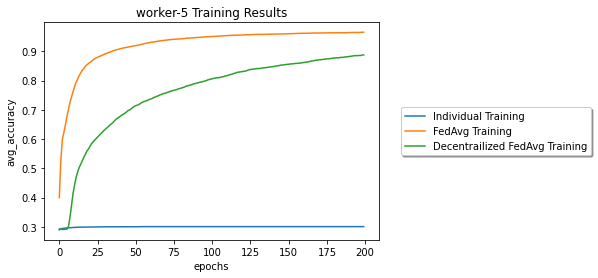

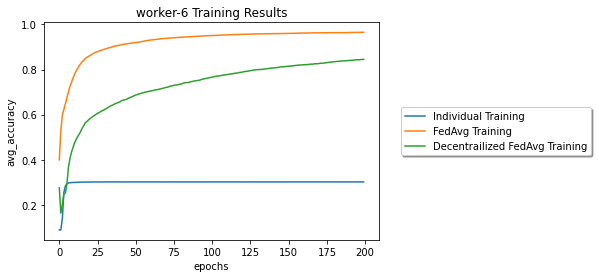

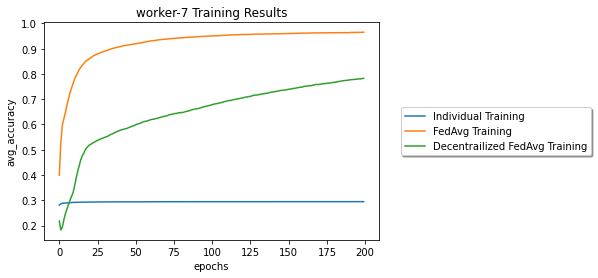

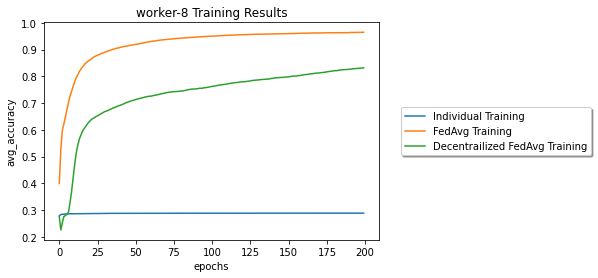

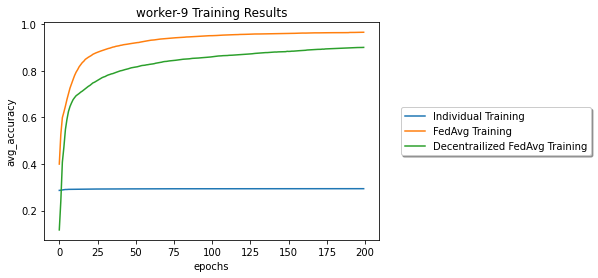

In [21]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes[-5:]:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()